In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')   # 定义数据格式
K.set_learning_phase(1)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import scipy.misc


# import resnets_utils 

%matplotlib inline



Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [2]:
###### 恒等快

def identity_block(X, f, filters, stage, block):
    """
    实现图3的恒等块
    
    参数：
        X - 输入的tensor类型的数据，维度为( m, n_H_prev, n_W_prev, n_H_prev )
        f - 整数，指定主路径中间的CONV窗口的维度
        filters - 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage - 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block - 字符串，据每层的位置来命名每一层，与stage参数一起使用。
        
    返回：
        X - 恒等块的输出，tensor类型，维度为(n_H, n_W, n_C)
    
    """
    
    #定义命名规则
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"
    
    #获取过滤器
    F1, F2, F3 = filters
    
    #保存输入数据，将会用于为主路径添加捷径
    X_shortcut = X
    
    #主路径的第一部分
    ##卷积层   kernel_initializer=glorot_uniform(seed=0)   0号种子随机初始化
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1) ,padding="valid",
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    #主路径的第二部分
    ##卷积层
    X = Conv2D(filters=F2, kernel_size=(f,f),strides=(1,1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    
    #主路径的第三部分
    ##卷积层
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2c")(X)
    ##没有ReLU激活函数
    
    #最后一步：
    ##将捷径与输入加在一起
    X = Add()([X,X_shortcut])
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    return X

In [3]:
###### 卷积块

def convolutional_block(X, f, filters, stage, block, s=2):
    """
    实现图5的卷积块
    
    参数：
        X - 输入的tensor类型的变量，维度为( m, n_H_prev, n_W_prev, n_C_prev)
        f - 整数，指定主路径中间的CONV窗口的维度
        filters - 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage - 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block - 字符串，据每层的位置来命名每一层，与stage参数一起使用。
        s - 整数，指定要使用的步幅
    
    返回：
        X - 卷积块的输出，tensor类型，维度为(n_H, n_W, n_C)
    """
    
    #定义命名规则
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"
    
    #获取过滤器数量
    F1, F2, F3 = filters
    
    #保存输入数据
    X_shortcut = X
    
    #主路径
    ##主路径第一部分
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding="valid",
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
    X = Activation("relu")(X)
    
    ##主路径第二部分
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)
    
    ##主路径第三部分
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2c")(X)
    
    #捷径
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding="valid",
               name=conv_name_base+"1", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,name=bn_name_base+"1")(X_shortcut)
    
    #最后一步
    X = Add()([X,X_shortcut])
    X = Activation("relu")(X)
    
    return X


In [4]:
p = 0.2

def ResNet_model(input_shape=(64,64,3),classes=6):
    """
    实现ResNet50
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    
    参数：
        input_shape - 图像数据集的维度
        classes - 整数，分类数
        
    返回：
        model - Keras框架的模型
        
    """
    
    #定义tensor类型的输入数据
    X_input = Input(input_shape)   # 64*64*3
    
    #0填充
    X = ZeroPadding2D((3,3))(X_input)   # 70*70*3     
    
    #stage1
    X = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), name="conv1",
               kernel_initializer=glorot_uniform(seed=0))(X)    # 默认填充方式为valid,  32*32*64，（70-7）/2+1
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D(pool_size=(3,3), strides=(2,2))(X)    # 15*15*64    （32-3）/2+1
    
    #stage2
    X = convolutional_block(X, f=3, filters=[64,64,256], stage=2, block="a", s=1)     # 卷积块，但是此处s=1，所以仍然是15*15*256
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block="b")    # 15*15*256  ,注意恒等块最后相加时维度要相同
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block="c")    # 15*15*256
    
    #stage3
    X = convolutional_block(X, f=3, filters=[128,128,512], stage=3, block="a", s=2)   # 8*8*512
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="b")   # 8*8*512
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="c")   # 8*8*512
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="d")   # 8*8*512
    
    # X = Dropout(p)(X)
    
    #stage4
    X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block="a", s=2)  # 4*4*1024
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="b")   # 4*4*1024
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="c")   # 4*4*1024
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="d")   # 4*4*1024
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="e")   # 4*4*1024
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="f")   # 4*4*1024
    
    # X = Dropout(p)(X)
       
    #stage5
    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=5, block="a", s=2)  # 2*2*2048
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block="b")    # 2*2*2048
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block="c")    # 2*2*2048
    
   # X = Dropout(p)(X)
      
    
    #均值池化层    same会根据具体的步长和核大小去尽量遍历特征图。即，除得尽和valid一样，除不尽向上取整。这里除得尽，2/2=1 。
    X = AveragePooling2D(pool_size=(2,2),padding="same")(X)    # 1*1*2048
    
    #输出层
    X = Flatten()(X)
    X = Dense(classes, activation="sigmoid", name="fc"+str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)
    
    
    #创建模型
    model = Model(inputs=X_input, outputs=X, name="ResNet_model")
    
    
    return model


In [5]:
from tensorflow.keras.initializers import *
from tensorflow.keras.layers import  Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

model = ResNet_model(input_shape=(200,200,3),classes=1)

model.summary()

model.compile(optimizer=Adam(lr=0.0002), loss="binary_crossentropy", metrics=["accuracy"])



Model: "ResNet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
_______________________________________________________________________________________

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
# import zipfile

# Define our example directories and files
train_dir = r'D:\大创\skin_cancer\train'
validation_dir = r'D:\大创\skin_cancer\test'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,   # 归一化
                                   rotation_range = 40,  # 旋转 0~40°
                                   width_shift_range = 0.2,  # 水平移动 0~ 20%
                                   height_shift_range = 0.2,  # 竖直移动0~20%
                                   shear_range = 0.2,     # 允许剪切，变形
                                   zoom_range = 0.2,        # 缩放0~20%
                                   horizontal_flip = True)  # 水平翻转

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'binary',
                                                    target_size = (200, 200))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 16,
                                                          class_mode  = 'binary',
                                                          target_size = (200, 200))


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [28]:
####  此处输入图片路径可以查看规定大小的图片


# img_path = r'D:\大创\kaggle\train\cat\cat.2982.jpg'
# img = image.load_img(img_path, target_size=(200, 200))
# imshow(img)

In [7]:
# 回调函数
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

   

In [10]:
# callbacks = myCallback()

history = model.fit(
    train_generator,   # 训练集图像生成器
    epochs=40,
    
    # validation_split = 0.2,   该选项不支持图片生成器
    
    #steps_per_epoch=2,   # 5391/128   可以不写，自动生成。
    validation_data = validation_generator,  # 测试集图像生成器
    verbose = 1,  # 每1个epoch显示一次结果
    #validation_steps=2,  # 1002/64   可以不写，自动生成
    #callbacks=[callbacks]   # 是否选择回调函数
)

Epoch 1/40


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node ResNet_model/conv1/Conv2D (defined at <ipython-input-8-777db5cfb865>:3) ]] [Op:__inference_train_function_13085]

Function call stack:
train_function


In [25]:
#### 对大量数据（validation_generator）进行预测

preds = model.evaluate(validation_generator, verbose=1, sample_weight=None)
print ("误差值 = " + str(preds[0]))
print ("准确度 = " + str(preds[1]))

2/2 [==============================] - 0s 28ms/step - loss: 2.6804 - accuracy: 0.5714
误差值 = 2.68035888671875
准确度 = 0.5714285969734192


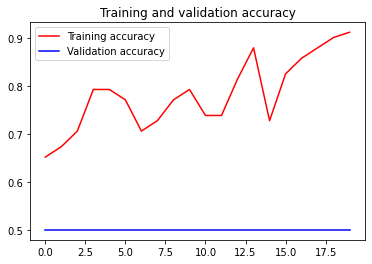

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

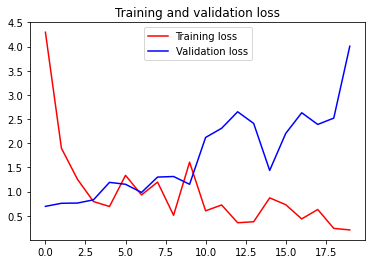

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [10]:
# 保存参数
file_path = './' + '验证集准确率' + str(int(preds[1]*1000)/1000)

print(file_path)

model.save_weights(file_path)

./验证集准确率0.87


In [8]:
# 载入参数
file_path = './验证集准确率0.555'

model.load_weights(file_path)

preds = model.evaluate(validation_generator, verbose=1, sample_weight=None)
print ("误差值 = " + str(preds[0]))
print ("准确度 = " + str(preds[1]))

3/3 [==============================] - 0s 18ms/step - loss: 1.3219 - accuracy: 0.5556
误差值 = 1.3219285011291504
准确度 = 0.5555555820465088


In [11]:
# 保存模型（结构和参数）
file_path = './' + '猫狗验证集准确率' + str(int(preds[1]*1000)/1000) + '.h5'

print(file_path)

model.save(file_path)

./猫狗验证集准确率0.87.h5


In [4]:
# 导入模型（结构和参数）
from tensorflow.keras.models import load_model

model = load_model('./猫狗验证集准确率0.835.h5')

preds = model.evaluate(validation_generator, verbose=1, sample_weight=None)
print ("误差值 = " + str(preds[0]))
print ("准确度 = " + str(preds[1]))


'''
详见Kears中文文档  《如何保存Keras模型？》
'''

41/41 [==============================] - 3s 64ms/step - loss: 0.3426 - accuracy: 0.8354 0s - loss: 0.3530 - ac
误差值 = 0.3426283895969391
准确度 = 0.8353941440582275


'\n详见Kears中文文档  《如何保存Keras模型？》\n'

In [13]:
model.metrics_names

['loss', 'accuracy']

[[0.02930445]]
0


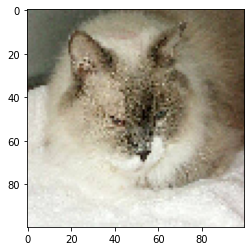

In [36]:
import numpy as np
# from google.colab import files
from tensorflow.keras.preprocessing import image

# uploaded = files.upload()

# for fn in uploaded.keys():
 
# predicting images
path = r''   # 此处填入图像路径
img = image.load_img(path, target_size=(100, 100))
imshow(img)
x = image.img_to_array(img)/255 # 归一化

x = np.expand_dims(x, axis=0)   # 扩展一个维度

# images = np.vstack([x])  # 按竖直方向堆叠
# classes = model.predict(images, batch_size=10)   # 对多个图像一起预测

classes = model.predict([x], batch_size=10)   # 预测

ans = np.squeeze(classes)   # 降维成实数

# print(path)
print(classes)
if ans > 0.5:
    print(1)
else:
    print(0)